In [1]:
import numpy as np
from scipy.sparse import csr_matrix, csc_matrix
import keras

Using TensorFlow backend.


In [2]:
import urllib2
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# link1: https://www.tensorflow.org/tutorials/seq2seq
# link2: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [4]:
from gensim.corpora import Dictionary
from sklearn.preprocessing import OneHotEncoder

class SentenceToCharVecEncoder:
    def __init__(self, dictionary):
        self.dictionary = dictionary
        numchars = len(self.dictionary)
        self.onehot_encoder = OneHotEncoder()
        self.onehot_encoder.fit(np.arange(numchars).reshape((numchars, 1)))
        
    def calculate_prelim_vec(self, cor_sent):
        return self.onehot_encoder.transform(
            np.array([self.dictionary.token2id[c] for c in cor_sent]).reshape((len(cor_sent), 1))
        )
        
    def encode_sentence(self, sent, startsig=False, endsig=False, maxlen=20):
        cor_sent = ('\n' if startsig else '')+sent[:min(maxlen, len(sent))]+('\n' if endsig else '')
        sent_vec = self.calculate_prelim_vec(cor_sent).tocsc()
        if sent_vec.shape[0]==maxlen+startsig+endsig:
            return sent_vec
        else:
            return csc_matrix((sent_vec.data, sent_vec.indices, sent_vec.indptr), 
                              shape=(maxlen+startsig+endsig, sent_vec.shape[1]), 
                              dtype=np.float64)
    
    def encode_sentences(self, sentences, sparse=True, startsig=False, endsig=False, maxlen=20):
        if sparse:
            return map(lambda sent: self.encode_sentence(sent, startsig=startsig, endsig=endsig, maxlen=maxlen), sentences)
        else:
            return map(lambda sent: self.encode_sentence(sent, startsig=startsig, endsig=endsig, maxlen=maxlen).toarray(), sentences)
    
def initSentenceToCharVecEncoder(textfile):
    text = filter(lambda t: len(t)>0, [t.strip()+'\n' for t in textfile])
    dictionary = Dictionary(map(lambda line: [c for c in line], text))
    return SentenceToCharVecEncoder(dictionary)

In [5]:
textfile = urllib2.urlopen('http://norvig.com/big.txt', 'r')
text = filter(lambda t: len(t)>0, [t.strip() for t in textfile])

In [6]:
chartovec_encoder = initSentenceToCharVecEncoder(text)

In [7]:
numchars = len(chartovec_encoder.dictionary)
latent_dim = numchars + 20

print numchars
print latent_dim

93
113


In [8]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, numchars))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, numchars))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(numchars, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [10]:
# preparing training data

In [17]:
encoder_input = chartovec_encoder.encode_sentences(text[:-1], startsig=True, maxlen=20)
decoder_input = chartovec_encoder.encode_sentences(text[1:], startsig=True, maxlen=20)
decoder_output = chartovec_encoder.encode_sentences(text[1:], endsig=True, maxlen=20)

In [18]:
print(len(encoder_input))
print(map(lambda e: e.shape, encoder_input[:100]))

103500
[(21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (2

In [19]:
print(len(decoder_input))
print(map(lambda e: e.shape, decoder_input[:100]))

103500
[(21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (2

In [20]:
print(len(decoder_output))
print(map(lambda e: e.shape, decoder_output[:100]))

103500
[(21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (21, 93), (2

In [9]:
chartovec_encoder.dictionary.token2id

{u'\t': 68,
 u'\n': 0,
 u' ': 1,
 u'!': 53,
 u'"': 41,
 u'#': 33,
 u'$': 78,
 u'%': 84,
 u'&': 77,
 u"'": 70,
 u'(': 34,
 u')': 35,
 u'*': 45,
 u'+': 83,
 u',': 42,
 u'-': 69,
 u'.': 38,
 u'/': 82,
 u'0': 59,
 u'1': 36,
 u'2': 60,
 u'3': 80,
 u'4': 79,
 u'5': 37,
 u'6': 55,
 u'7': 50,
 u'8': 73,
 u'9': 51,
 u':': 54,
 u';': 74,
 u'<': 85,
 u'=': 90,
 u'>': 86,
 u'?': 75,
 u'@': 87,
 u'A': 2,
 u'B': 3,
 u'C': 28,
 u'D': 29,
 u'E': 4,
 u'F': 46,
 u'G': 5,
 u'H': 6,
 u'I': 43,
 u'J': 63,
 u'K': 64,
 u'L': 62,
 u'M': 56,
 u'N': 61,
 u'O': 65,
 u'P': 7,
 u'Q': 76,
 u'R': 52,
 u'S': 8,
 u'T': 9,
 u'U': 66,
 u'V': 47,
 u'W': 48,
 u'X': 71,
 u'Y': 44,
 u'Z': 81,
 u'[': 57,
 u']': 58,
 u'^': 91,
 u'_': 88,
 u'a': 30,
 u'b': 10,
 u'c': 11,
 u'd': 12,
 u'e': 13,
 u'f': 14,
 u'g': 15,
 u'h': 16,
 u'i': 31,
 u'j': 17,
 u'k': 18,
 u'l': 19,
 u'm': 20,
 u'n': 21,
 u'o': 22,
 u'p': 39,
 u'q': 72,
 u'r': 23,
 u's': 24,
 u't': 25,
 u'u': 26,
 u'v': 27,
 u'w': 40,
 u'x': 49,
 u'y': 32,
 u'z': 67,
 u'|': 

(array([    0.,     5.,    56.,   332.,  1044.,  1180.,  1242.,  1187.,
         1057.,   988.,   935.,   761.,   607.,   497.,   464.,   428.,
          422.,   509.,   420.,   431.,   419.,   392.,   395.,   397.,
          393.,   391.,   387.,   365.,   351.,   333.,   335.,   304.,
          300.,   317.,   345.,   343.,   304.,   345.,   282.,   316.,
          324.,   272.,   278.,   304.,   263.,   250.,   313.,   269.,
          548.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 <a list of 49 Patch objects>)

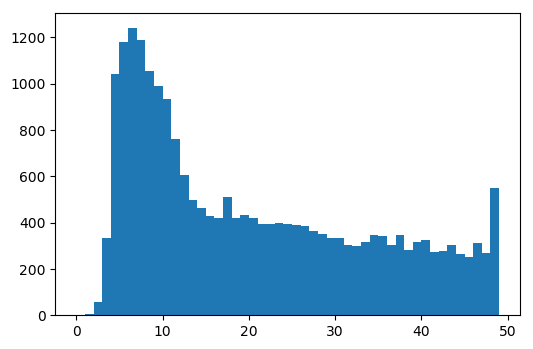

In [18]:
plt.hist(map(lambda t: t.shape[0], chartovec_encoder.encode_sentences(text)), bins=np.arange(50))

(array([  1.02736000e+05,   3.63000000e+02,   1.58000000e+02,
          1.69000000e+02,   3.80000000e+01,   2.30000000e+01,
          7.00000000e+00,   2.00000000e+00,   4.00000000e+00,
          1.00000000e+00]),
 array([  1.00000000e+00,   2.55000000e+02,   5.09000000e+02,
          7.63000000e+02,   1.01700000e+03,   1.27100000e+03,
          1.52500000e+03,   1.77900000e+03,   2.03300000e+03,
          2.28700000e+03,   2.54100000e+03]),
 <a list of 10 Patch objects>)

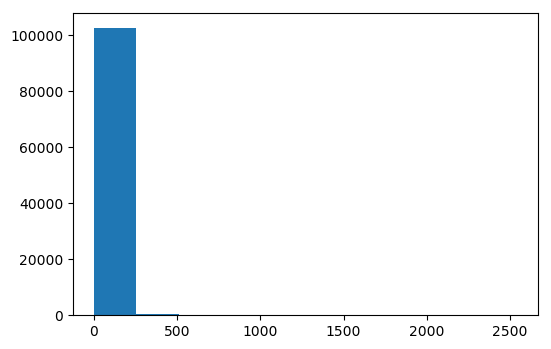

In [17]:
plt.hist(map(lambda t: t.shape[0], chartovec_encoder.encode_sentences(text)))

In [10]:
vec = chartovec_encoder.calculate_prelim_vec('\nInternally').tocsc()

In [11]:
vec.shape

(11, 93)

In [12]:
csc_matrix((vec.data, vec.indices, vec.indptr), shape=(21, 93))

<21x93 sparse matrix of type '<type 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Column format>

In [13]:
chartovec_encoder.encode_sentence('Internally', startsig=True, maxlen=20).toarray()

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [16]:
np.array(chartovec_encoder.encode_sentences(text[21:23], sparse=False))

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]])

In [22]:
encoder_input[0].toarray()

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [23]:
decoder_input[0].toarray()

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.]])

In [25]:
decoder_output[0].toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.]])